## Lossless Compression with Machine Learning
#### Author: Mingtian Zhang

In [56]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Binary MNIST

train_data_size (10000, 784)
test_data_size (10000, 784)


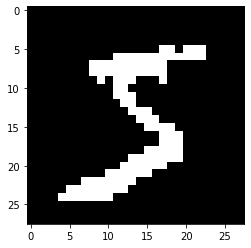

In [55]:
train_data=torchvision.datasets.MNIST('../data', train=True, download=False,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('../data', train=False, download=False,transform=torchvision.transforms.ToTensor())
train_data_list=[]
test_data_list=[]
for x,_ in train_data:
    train_data_list.append(torch.round(x).numpy())
    
for x,_ in test_data:
    test_data_list.append(torch.round(x).numpy())
    
train_data=np.stack(train_data_list).reshape(60000,784)
test_data=np.stack(test_data_list).reshape(-1,784)
print('train_data_size',np.shape(test_data))
print('test_data_size',np.shape(test_data))
plt.imshow(train_data[0].reshape(28,28),cmap="gray")
plt.show()

### Independent Multivariate Bernoulli

In [61]:
model=np.mean(train_data,0)+0.00001
encode_total=-(test_data[0]*np.log2(model)+(1-test_data[0])*np.log2(1-model)).sum()
encode_per_dim=encode_total/784
print('total bits of one test imgae:',encode_total)
print('bits per dim of one test image:', encode_per_dim)

total bits of one test imgae: 256.33142
bits per dim of one test image: 0.3269533429827009


### Arithmetic Coding

In [63]:
from decimal import *
getcontext().prec = 200
import math

def bin_2_float(binary):
        prob = Decimal(0.0)
        for index, i in enumerate(binary):
            power=index+1
            prob += ((Decimal(2) ** (-power)) * int(i))
        return prob

def range_2_bin(low,high):
    code = [] 
    prob = Decimal(0.0)
    while(prob < low):
        code.append(1)
        prob = bin_2_float(code)
        if prob > high:
            code[-1] = 0
        prob = bin_2_float(code)
    return code

def encode(data,model):
    model=model.reshape(784,1)
    p0_table=np.concatenate((np.zeros((784,1)),1-model),1).reshape(784,1,2)
    p1_table=np.concatenate((1-model,np.ones((784,1))),1).reshape(784,1,2)
    p_list=np.concatenate((p0_table,p1_table),1)
    o_low = Decimal(0.0)
    o_high = Decimal(1.0)
    _range = Decimal(1.0)

    for i,s in enumerate(data.astype(int)):
        low  = o_low + _range * Decimal(p_list[i,s,0])
        high = o_low + _range * Decimal(p_list[i,s,1])
        _range = high - low
        o_low = low
        o_high = high
    code=range_2_bin(low,high)
    return code

def decode(code,model):
    model=model.reshape(784,1)
    p0_table=np.concatenate((np.zeros((784,1)),1-model),1).reshape(784,1,2)
    p1_table=np.concatenate((1-model,np.ones((784,1))),1).reshape(784,1,2)
    p_list=np.concatenate((p0_table,p1_table),1)
    data=[]
    prob = bin_2_float(code)
    low = Decimal(0.0)
    high = Decimal(1.0)
    _range = Decimal(1.0)
    last=0
    
    for i in range(0,784):
        for s in [0,1]:
            if Decimal(p_list[i,s,0])<=prob and prob<Decimal(p_list[i,s,1]):
                data.append(s)
                last=s
            else:
                pass
        low=Decimal(p_list[i,last,0])
        high=Decimal(p_list[i,last,1])
        _range=high-low
        prob=(prob-low)/_range

    return data

### Test

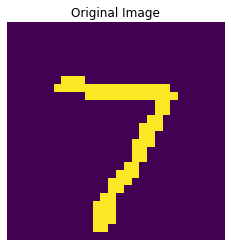

compression length: 256 bits
bits per dim: 0.32653061224489793


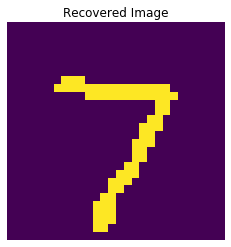

In [70]:
plt.title('Original Image')
plt.imshow(np.asarray(test_data[0]).reshape(28,28))
plt.axis('off')
plt.show()
code=encode(test_data[0],model)
print('compression length:', len(code),'bits')
print('bits per dim:', len(code)/784)
data=decode(code,model)
plt.title('Recovered Image')
plt.imshow(np.asarray(data).reshape(28,28))
plt.axis('off')
plt.show()